# Test DINOv2 feature extraction capabilibites on selected datasets

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from torchvision import transforms

from kiss.feature_extractor import DinoFeatureExtractor

feature_extractor = DinoFeatureExtractor()

Using cache found in /Users/michal/.cache/torch/hub/facebookresearch_dinov2_main
/Users/michal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/michal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/michal/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


## Load dataset

In [3]:
EMBEDDING_SIZE = 768
BATCH_SIZE = 64
SAMPLES_PER_CLASS = 100

# CIFAR10
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='../../data/cifar10', train=True, download=True, transform=transform)
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_targets = train_dataset.targets

# SVHN
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = torchvision.datasets.SVHN(root='../../data/svhn', split='train', download=True, transform=transform)
# CLASSES = [f'number {i}' for i in range(10)]
# train_targets = train_dataset.labels

N_CLASSES = len(CLASSES)

train_indices = []

for class_label in range(N_CLASSES):
    class_indices = [i for i, label in enumerate(train_targets) if label == class_label]
    train_indices.extend(class_indices[:SAMPLES_PER_CLASS])

train_set = torch.utils.data.Subset(train_dataset, train_indices)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


## Plot random samples

/Users/michal/mambaforge/envs/kiss/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/michal/mambaforge/envs/kiss/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


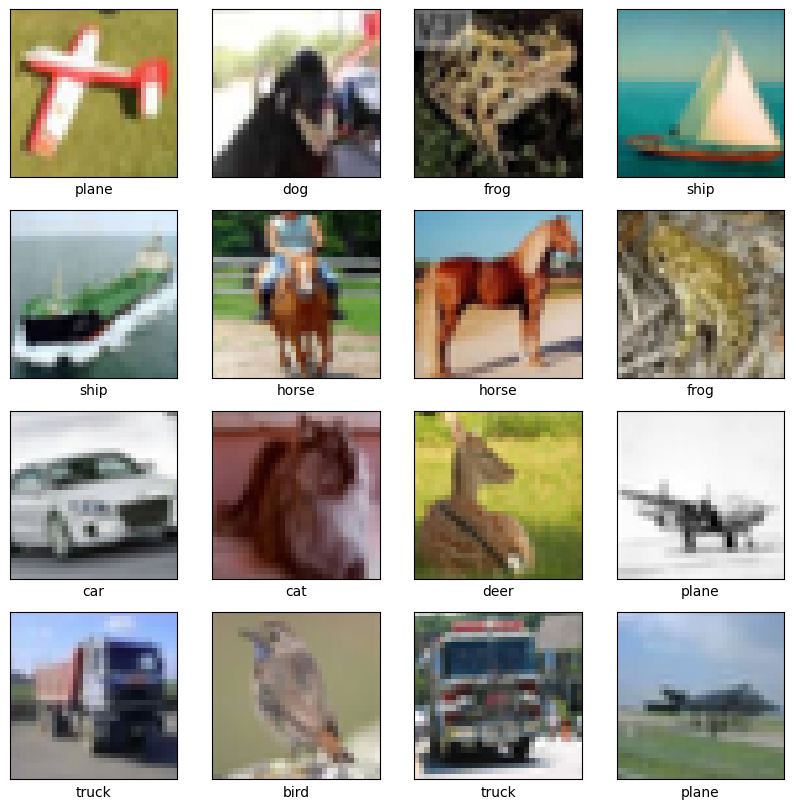

In [4]:
def show_images(imgs, labels, classes):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = imgs[i]
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_xlabel(classes[labels[i]])
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

show_images(images, labels, CLASSES)

## Plot samples with visualized DINOv2 features

/Users/michal/mambaforge/envs/kiss/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/michal/mambaforge/envs/kiss/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


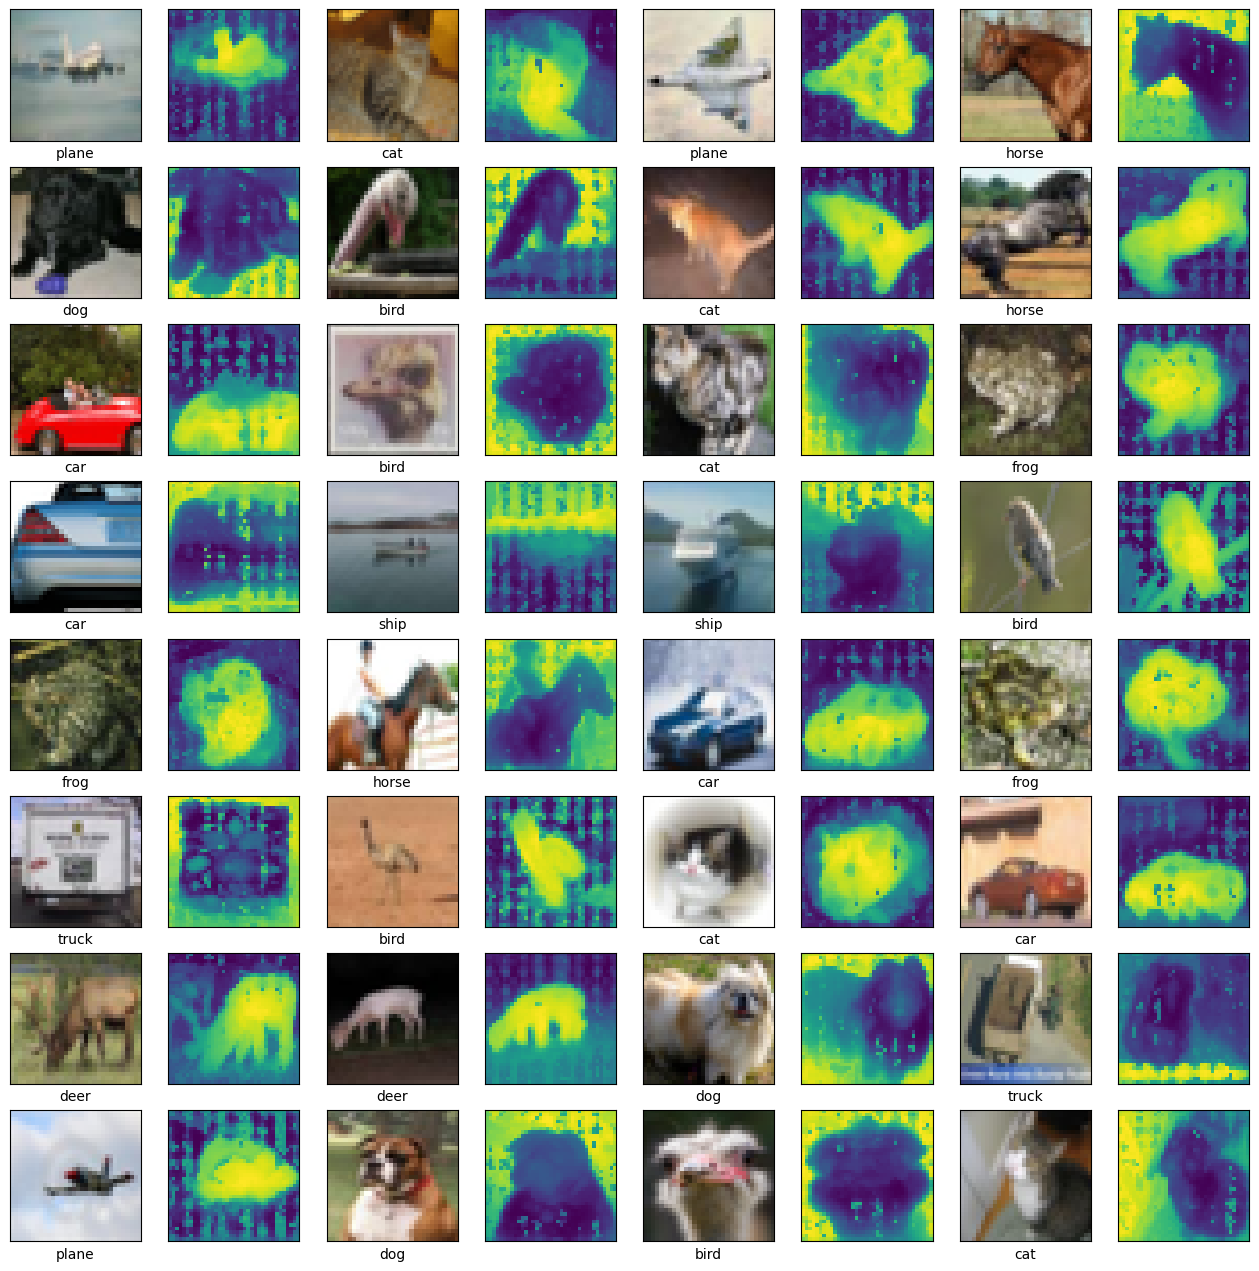

In [5]:
def dino_features_to_img(img_features, patch_h, patch_w):
    pca = PCA(n_components=3)
    pca.fit(img_features)
    pca_features = pca.transform(img_features)

    pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                        (pca_features[:, 0].max() - pca_features[:, 0].min())

    return pca_features[:, 0].reshape(patch_h, patch_w)

def show_images(imgs, labels, classes, transform=None):
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    
    for i in range(8):
        for j in range(4):
            # Display original image on the left side
            img_idx = i * 4 + j
            ax = axes[i, j * 2]
            
            img = imgs[img_idx]
            img = img.numpy().transpose(1, 2, 0)
            ax.imshow(img)
            ax.set_xlabel(classes[labels[img_idx]])
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            
            # Display transformed image on the right side
            if transform is not None:
                ax = axes[i, j * 2 + 1]
                features = feature_extractor(imgs[img_idx].unsqueeze(0), mean=False)
                img_features = dino_features_to_img(features[0], feature_extractor.patch_h, feature_extractor.patch_w)
                ax.imshow(img_features)
                # ax.set_xlabel(f'Transformed {classes[labels[img_idx]]}')
                plt.setp(ax.get_xticklabels(), visible=False)
                plt.setp(ax.get_yticklabels(), visible=False)
                ax.tick_params(axis='both', which='both', length=0)
    
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

show_images(images, labels, CLASSES, transform=transform)